In [42]:
import os, sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('./s2spy')
from s2spy import RGDR, time
import utils, plotting
path_obs_data = '/data/volume_2/observational/'
path_subseasonal_data = '/data/volume_2/subseasonal/'

In [8]:
sst = xr.open_dataarray(os.path.join(path_obs_data, 'raw', 'era5_sst_1959-2021_1_12_daily_2.0deg.nc'))


In [2]:
target = xr.open_dataarray(os.path.join(path_obs_data, 'preprocessed', 'chrips_precip_1981-2021_africa_aggregated_intervals.nc'))
target

<xarray.DataArray 'precip' (anchor_year: 41, target_period: 10, latitude: 79,
                            longitude: 72)>
[2332080 values with dtype=float32]
Coordinates:
  * anchor_year    (anchor_year) int64 1981 1982 1983 1984 ... 2019 2020 2021
  * target_period  (target_period) int64 0 1 2 3 4 5 6 7 8 9
  * longitude      (longitude) float64 33.12 33.38 33.62 ... 50.38 50.62 50.88
  * latitude       (latitude) float64 -4.625 -4.375 -4.125 ... 14.38 14.62 14.88
    target         bool ...

In [15]:
hoa_mask = xr.open_dataarray(os.path.join(path_obs_data, 'chirps_hoa_dry_mask_0.25deg.nc'))
target_timeseries = target.where(hoa_mask).mean(dim=('latitude', 'longitude'))

In [16]:
dfs = pd.read_hdf('/data/volume_2/subseasonal/ecmwf/aggregated/aggregation_timestamps.h5').sort_index()
df = dfs[['aggregation_start_inclusive', 'aggregation_end_inclusive']].copy()
sel_months = [10, 11, 12]
mon_start_mask = [True if m in sel_months else False for m in df.set_index('aggregation_start_inclusive').index.month]
mon_end_mask = [True if m in sel_months else False for m in df.set_index('aggregation_end_inclusive').index.month]
mon_mask = np.logical_and(mon_start_mask, mon_end_mask)
df_sub = dfs[mon_mask][dfs[mon_mask].index.year==dfs[mon_mask].index.year[0]]
anchor_dates = [(d.month, d.day) for d in df_sub.index]

In [17]:
anchor_date = anchor_dates[0]

In [6]:
cal = time.AdventCalendar(anchor=anchor_date, freq='30d', max_lag=4)
cal = cal.map_years(1981, 2021)

In [10]:
sst_resampled = time.resample(cal, sst)

In [18]:
rgdr = RGDR(target_timeseries.sel(target_period=0), eps_km=600, alpha=0.05, min_area_km2=3000**2)

In [29]:
rgdr.fit(sst_resampled['sst'].sel(i_interval=1))

<xarray.DataArray 'sst' (cluster_labels: 3, anchor_year: 41)>
array([[291.28808584, 291.25151299, 291.30396773, 291.24831588,
        291.27468699, 291.2482061 , 291.46082358, 291.38466539,
        291.33323751, 291.46328897, 291.41239237, 291.27005941,
        291.28018664, 291.31247015, 291.46062587, 291.37487017,
        291.56415468, 291.63126441, 291.39455705, 291.45947837,
        291.55603656, 291.5243669 , 291.59842555, 291.60690688,
        291.63772542, 291.58095033, 291.5092686 , 291.59326371,
        291.69023249, 291.65567365, 291.57724895, 291.66301944,
        291.68152558, 291.72951325, 291.82327298, 291.87871247,
        289.53845215, 289.19976807, 289.46252441, 291.86794346,
        291.82287619],
       [286.9278269 , 287.76576911, 286.96248855, 287.1982638 ,
        286.43099733, 286.10932749, 286.86804736, 286.47461924,
        286.92957547, 286.95846805, 287.36869318, 286.84012975,
        286.1480543 , 287.31874057, 287.97063218, 286.78257178,
        288.82880725, 286.91253117, 287.64019787, 287.23150805,
        287.80928289, 287.8386052 , 288.46165439, 287.71112403,
        287.60819329, 288.45834253, 287.61773246, 287.83610293,
        287.78363548, 287.73926311, 286.94710053, 287.72285182,
        288.01388154, 288.66981266, 286.50220276, 287.36338071,
        289.53845215, 289.19976807, 289.46252441, 287.30241691,
        288.2328507 ],
       [288.85841434, 289.91139671, 290.67968481, 288.64035667,
        288.71112973, 289.10819897, 289.91823589, 288.4506323 ,
        289.11626401, 288.77233405, 289.35795246, 289.09450237,
        289.14792361, 289.13327329, 288.82866615, 288.8039049 ,
        291.74476056, 290.0256912 , 288.69744866, 288.73221959,
        288.88146866, 288.77652736, 288.96770666, 289.02326205,
        288.84477429, 289.75120246, 287.93537145, 289.53878588,
        289.37824719, 288.13464082, 288.80340451, 289.33241899,
        288.68040895, 289.04819849, 289.85646039, 289.67090281,
        289.53845215, 289.19976807, 289.46252441, 289.08583765,
        289.11854961]])
Coordinates:
  * anchor_year     (anchor_year) int64 1981 1982 1983 1984 ... 2019 2020 2021
    i_interval      int64 1
    index           (anchor_year) int64 1 6 11 16 21 26 ... 181 186 191 196 201
    interval        (anchor_year) object (1981-07-19, 1981-08-18] ... (2021-0...
    target          bool False
  * cluster_labels  (cluster_labels) float64 0.0 4.0 10.0
    latitude        (cluster_labels) float64 nan 56.54 -22.62
    longitude       (cluster_labels) float64 nan -9.287 -76.47

Plotting Corr maps None, split 0, lag 0
Plotting Corr maps None, split 0, lag 0
Plotting Corr maps None, split 0, lag 0


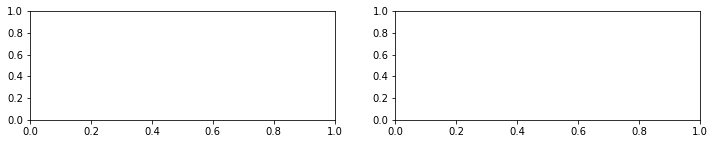

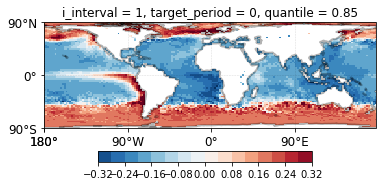

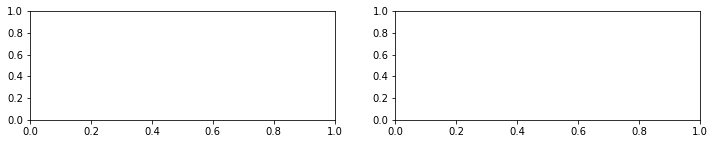

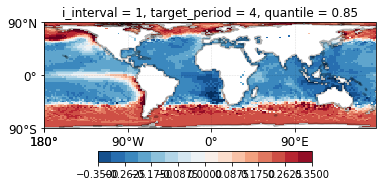

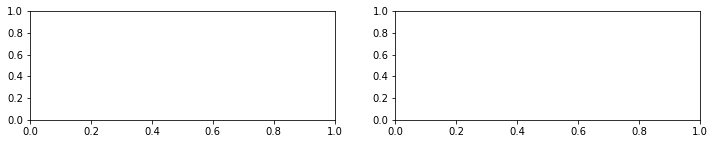

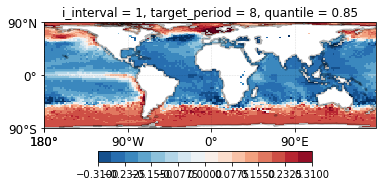

In [45]:
for period in target_timeseries.target_period.values[::4]:
    # rgdr = RGDR(target_timeseries.sel(target_period=int(period)), eps_km=600, alpha=0.05, min_area_km2=3000**2)
    corr, pval = rgdr.rgdr.correlation(sst_resampled['sst'].sel(i_interval=1), target_timeseries.sel(target_period=int(period)),
                                       corr_dim='anchor_year')
    plotting.plot_maps(corr)

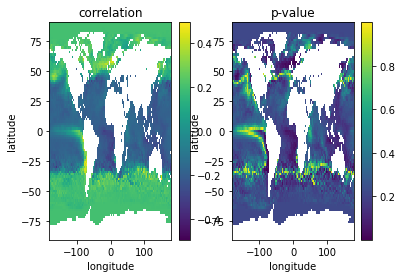

In [30]:
rgdr.plot_correlation(sst_resampled['sst'].sel(i_interval=1))